In [23]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp

import numpy as np
from scipy.optimize import minimize
import ipi_project as ipi
import phantoms
from skimage.filters import gaussian

import scipy.optimize

import matplotlib.pyplot as plt

import astra

from topolar import topolar

import scipy.sparse
from matrixT import create_T
from matrixT import create_Dx
from matrixT import create_Blur
from matrixT import create_Mask

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


18.10193359837562


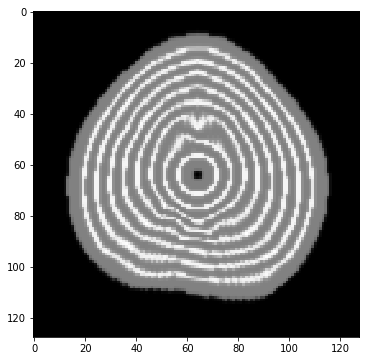

18.10193359837562


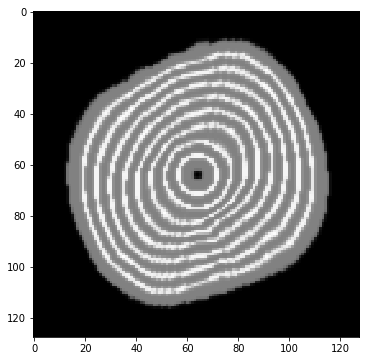

18.10193359837562


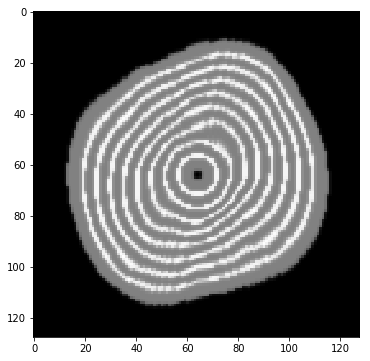

18.10193359837562


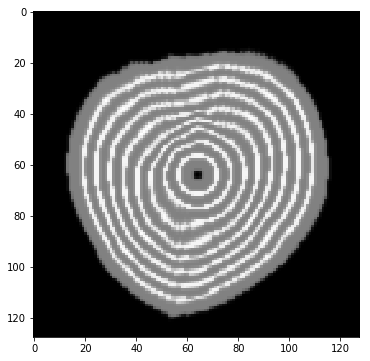

18.10193359837562


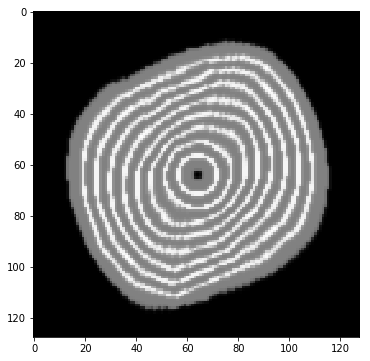

In [2]:
circle = phantoms.circle(128,12, wall_thickness=7)
#circle = np.pad(circle, pad_width=10, mode='constant', constant_values=0)
circle = gaussian(circle, sigma=0.5, preserve_range=True)
for _ in range(5):
    wobbly, src, inv_src = phantoms.wobbly_transform(circle, amplitude=5)
    #wobbly = gaussian(wobbly, sigma=1.0, preserve_range=True)


    plt.figure(figsize=(6,6))
    plt.imshow(wobbly, cmap='gray')
    plt.show()

In [3]:
A = ipi.astra_proj_matrix(128, proj_size=circle.shape[0], proj_angles=np.linspace(0, 2.0*np.pi, 5))

In [18]:
A.shape

(320, 4096)

In [5]:
print("A ", A.shape)
type(A)
print("A flat", np.ravel(A).shape)
print("Circle flat", circle.ravel().shape)

A  (320, 4096)
A flat (1,)
Circle flat (4096,)


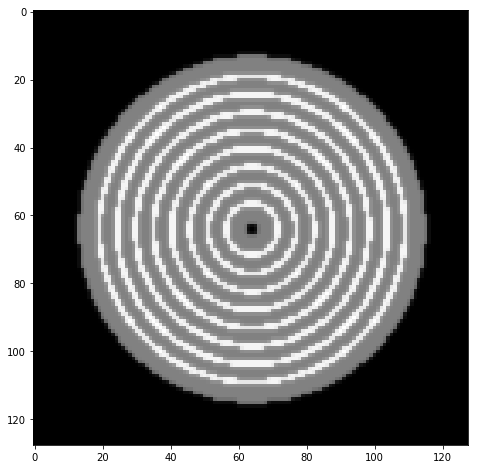

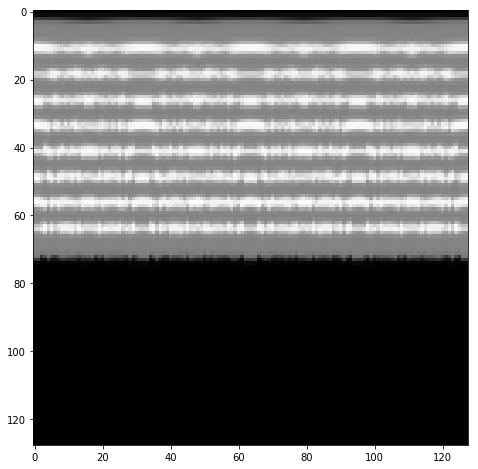

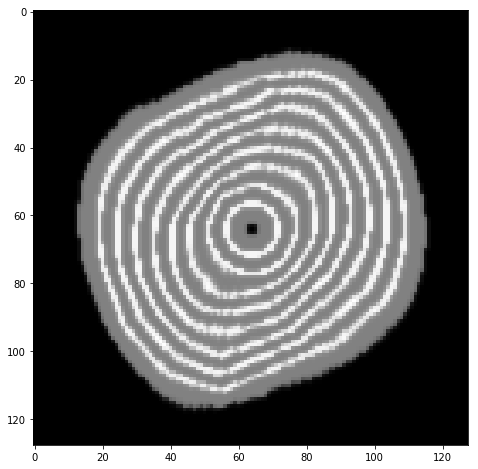

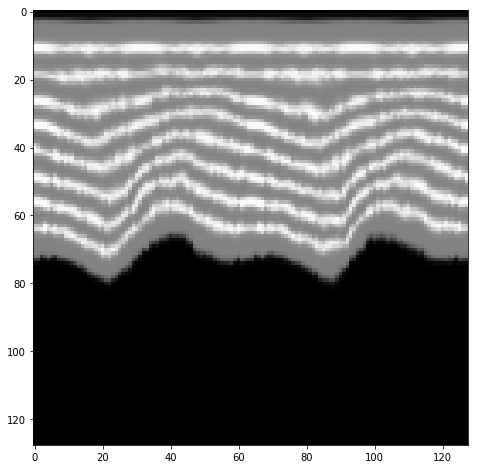

In [4]:
proj_angles = np.linspace(0, 2.0*np.pi, 180)
W, proj_id = ipi.create_OpTomo(circle.shape[0], proj_size=150, proj_angles=proj_angles)

matrix_id = astra.projector.matrix(proj_id)

A = astra.matrix.get(matrix_id)

def polar_and_sinogram(phantom, proj_id, plot=False):

    sino = astra.creators.create_sino(phantom, proj_id)[1]

    polar = topolar(phantom)[0]

    if plot:
        plt.figure(figsize=(8,8))
        plt.imshow(phantom, cmap='gray')
        plt.show()
        
        plt.figure(figsize=(8,8))
        plt.imshow(polar, cmap='gray')
        plt.show()
        #plt.imshow(sino, cmap='gray')
        #plt.show()
        
    return polar, sino
    
    
polar, sino = polar_and_sinogram(circle, proj_id, plot=True)
_ = polar_and_sinogram(wobbly, proj_id, plot=True)

In [175]:
def make_forward_diff(size):
    Dx = np.diag([1.0]*size) - np.diag([1.0]*(size -1), k=1)
    Dx[-1,0] = -1.0
    return Dx
                                     

In [176]:
def polar_line_regularization(image, Dx):
    polar_img = topolar(image)[0]
    diff_x =  polar_img @ Dx
    plt.imshow(np.abs(diff_x), cmap='gray')
    plt.show()
    return diff_x

In [4]:
Dx = make_forward_diff(circle.shape[0])

polar_perfect = np.zeros_like(circle)
polar_perfect[ [i for i in range(circle.shape[0]) if i % 4 == 0 and i < circle.shape[0] // 2] ] = 1.0

plt.imshow(polar_perfect, cmap='gray')
plt.show()
perfect_reg =  polar_perfect @ Dx

circ_reg = polar_line_regularization(circle, Dx)
wobbly_reg = polar_line_regularization(wobbly, Dx)

print("Perf Polar reg", np.linalg.norm(perfect_reg))
print("Circ reg", np.linalg.norm(circ_reg))
print("Wobbly reg", np.linalg.norm(wobbly_reg))

NameError: name 'make_forward_diff' is not defined

In [30]:
np.min(wobbly_reg)

-0.9843426487778295

In [31]:
np.max(wobbly_reg)

0.9791185179216253

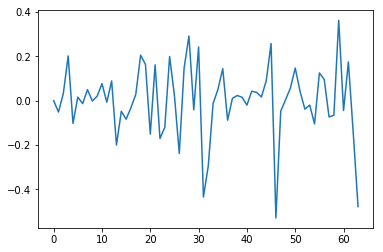

In [26]:
plt.plot(wobbly_reg[20])

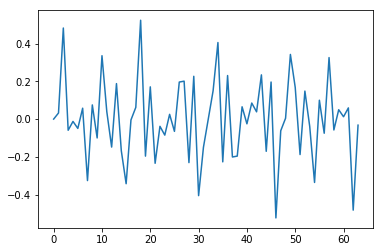

In [27]:
plt.plot(circ_reg[20])

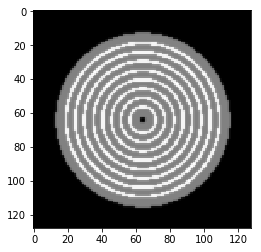

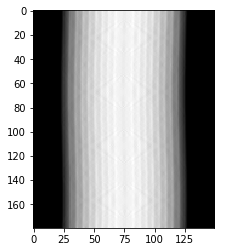

In [5]:
y = A @ circle.ravel()

circle_sino = y.reshape(180,150)

plt.imshow(circle, cmap='gray')
plt.show()

plt.imshow(circle_sino, cmap='gray')

## Unregularized least square

In [ ]:
x_sol = scipy.sparse.linalg.lsqr(A, y)

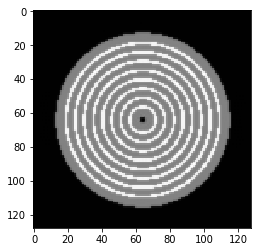

In [7]:
plt.imshow(x_sol[0].reshape(128,128), cmap='gray')

In [26]:
Tmat= create_T(128)


In [27]:
np.save("Tmat_128.np", Tmat)

## Topolar and Dx test

In [14]:
Dx_sparse = create_Dx(128)

In [29]:
Tmat_sparse = scipy.sparse.csr_matrix(Tmat)

In [42]:
G = create_Blur(128, 0.6)

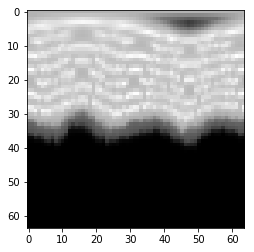

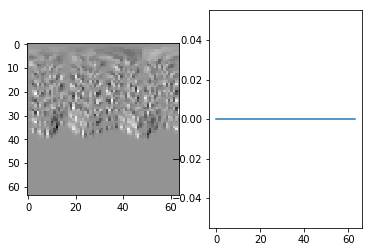

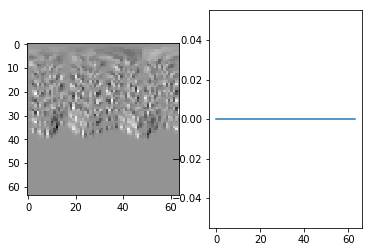

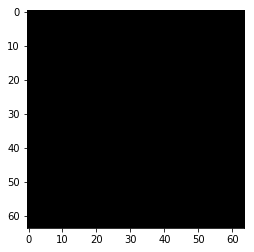

In [16]:
polar_wobbly = (Tmat_sparse @ wobbly.ravel())
plt.imshow(polar_wobbly.reshape(64,64), cmap='gray')
plt.show()

polar_wobbly_dx = Dx_sparse @ polar_wobbly
plt.subplot(121)
plt.imshow(polar_wobbly_dx.reshape(64,64), cmap='gray')
plt.subplot(122)
plt.plot((polar_wobbly_dx.reshape(64,64)[50]))
plt.show()

polar_wobbly2d = polar_wobbly.reshape(64,64)
polar_wobbly_dx_by_hand = polar_wobbly2d - np.roll(polar_wobbly2d, 1, axis=1)

plt.subplot(121)
plt.imshow(polar_wobbly_dx_by_hand, cmap='gray')
plt.subplot(122)
plt.plot(polar_wobbly_dx_by_hand[50])
plt.show()

plt.imshow(np.abs(polar_wobbly_dx.reshape(64,64) - polar_wobbly_dx_by_hand), cmap='gray')
plt.show()

Regularized


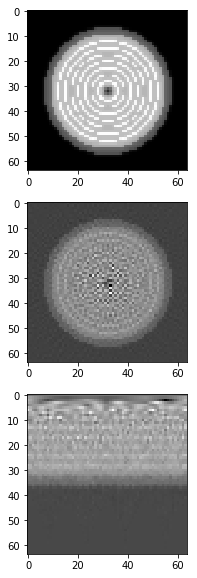

In [124]:
AT = scipy.sparse.vstack((A,  0.04 * Dx_sparse @ Tmat_sparse)) # @ create_Blur(64, 0.5)))

y_reg = np.zeros(AT.shape[0])

noise = np.random.randn(*y.shape)

y_reg[0:y.shape[0]] = y + 0.25*noise

x_sol_reg = scipy.sparse.linalg.lsqr(AT, y_reg)

print("Regularized")
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(x_sol[0].reshape(64,64), cmap='gray')
plt.subplot(312)
plt.imshow(x_sol_reg[0].reshape(64,64), cmap='gray')
plt.subplot(313)
plt.imshow(topolar(x_sol_reg[0].reshape(64,64))[0], cmap='gray')
plt.show()

In [125]:
np.min(x_sol_reg[0])

-1.9027359594624096

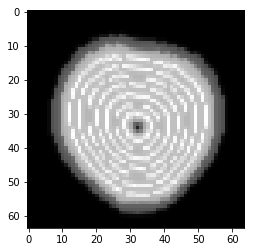

In [40]:
# No Regularization
plt.imshow(x_sol[0].reshape(64,64), cmap='gray')

In [99]:
y_reg = scipy.sparse.csr_matrix((AT.shape[0], 1))

In [100]:
y_reg[0:y.shape[0]] = y

/home/fgustafsson/venv/tf_14/lib/python3.5/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [32]:
x_sol_reg = scipy.sparse.linalg.lsqr(AT, y_reg)

NameError: name 'AT' is not defined

In [102]:
AT.shape

(31096, 4096)

In [103]:
y_reg.shape

(31096, 1)

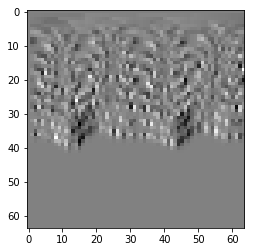

In [142]:
plt.imshow( (Tmat @ wobbly.ravel()).reshape(64,64) @ Dx, cmap='gray')

In [105]:
y.shape

(27000, 1)

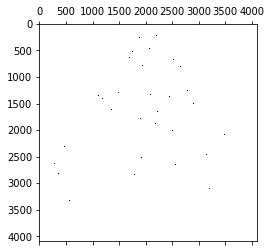

In [144]:
plt.spy(Tmat)

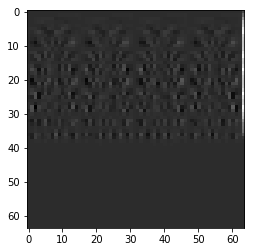

In [160]:
dtc = (Dx_sparse @ Tmat_sparse @ circle.ravel()).reshape(64,64)
plt.imshow(dtc, cmap='gray')

## Least squares with L1

In [40]:
G = create_Blur(64, 0.6)

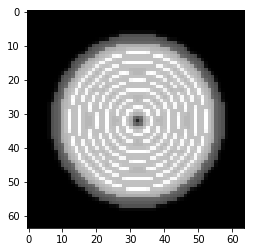

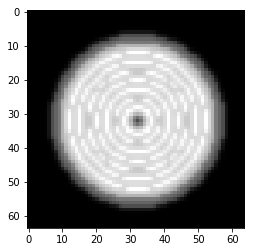

In [41]:
plt.imshow(circle, cmap='gray')
plt.show()

blurred_circle = (G @ circle.ravel()).reshape(64,64)
plt.imshow(blurred_circle, cmap='gray')

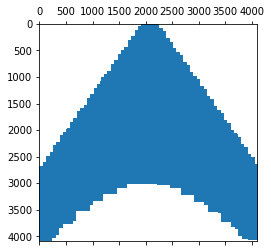

In [94]:
plt.spy(Tmat_sparse)

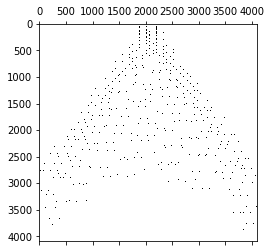

In [100]:
plt.spy(Dx_sparse @ Tmat_sparse @ create_Blur(64, 0.5))

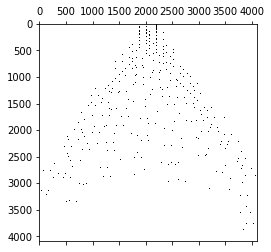

In [101]:
plt.spy(Tmat_sparse @ create_Blur(64, 0.5))

In [103]:
scipy.sparse.linalg.norm(Tmat_sparse)

38.45947640647606

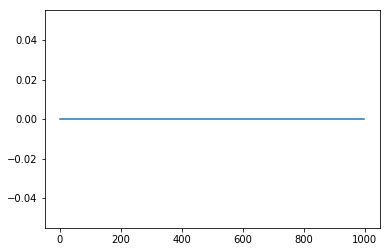

In [114]:
plt.plot(Tmat_sparse.toarray()[2000,2000:3000])

In [55]:
def reconstruct_with_constraints(A, y_sino, Mask, Tmat, Dx, reg_lambda):
    print(A.shape)
      
    
    def loss_fn(A, x, y_sino):
        Tmat_x = cp.matmul(Tmat, x)
        Mask_tmat = cp.matmul(Mask, Tmat_x)
        Dx_mask = cp.matmul(Dx, Mask_tmat)
        return cp.pnorm(cp.matmul(A, x) - y_sino, p=2)**2 + reg_lambda*cp.norm(Dx_mask, p=1)
    
    x = cp.Variable(128*128)
    constraints = [0 <= x]
    problem = cp.Problem(cp.Minimize(loss_fn(A, x, y_sino)), constraints)
    problem.solve(verbose=True, solver=cp.SCS, max_iters=3000)
    return x

In [ ]:
Dx = create_Dx(128)
Mask = create_Mask(128, 64)

(27000, 16384)
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6673967, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 16388, constraints m = 59776
Cones:	linear vars: 16384
	soc vars: 43392, soc blks: 4
Setup time: 2.23e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.31e-01  8.03e-01  9.99e-01 -1.33e+03  2.45e+01  0.00e+00  1.11e+00 
   100| 5.73e-02  5.11e-01  6.09e-01  5.94e+02  1.44e+02  4.53e+02  5.28e+01 
   200| 2.16e-02  5.11e-02  1.93e-02  6.

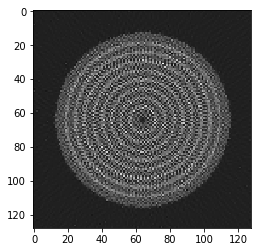

(27000, 16384)
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6673967, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 16388, constraints m = 59776
Cones:	linear vars: 16384
	soc vars: 43392, soc blks: 4
Setup time: 2.25e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.31e-01  1.17e+00  1.00e+00 -3.58e+03  6.60e+01  0.00e+00  1.10e+00 
   100| 1.14e-02  3.17e-02  4.91e-02  1.41e+02  1.28e+02  5.11e+00  3.83e+01 
   200| 1.41e-02  2.84e-02  2.65e-02  6.

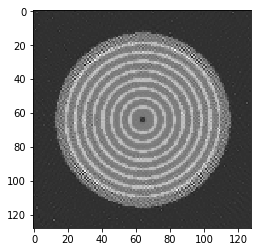

(27000, 16384)
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6673967, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 16388, constraints m = 59776
Cones:	linear vars: 16384
	soc vars: 43392, soc blks: 4
Setup time: 2.25e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.31e-01  1.34e+00  1.00e+00 -6.77e+03  1.25e+02  0.00e+00  1.10e+00 
   100| 2.72e-01  8.47e-01  1.50e-01  4.92e+03  3.64e+03  8.96e-12  3.86e+01 
   200| 1.92e-02  5.79e-02  5.44e-02  8.

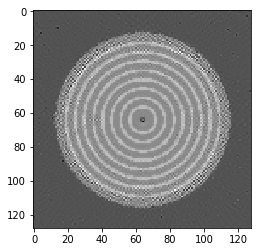

(27000, 16384)
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6673967, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 16388, constraints m = 59776
Cones:	linear vars: 16384
	soc vars: 43392, soc blks: 4
Setup time: 2.25e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.31e-01  1.42e+00  1.00e+00 -1.01e+04  1.86e+02  0.00e+00  1.09e+00 
   100| 1.57e-02  7.65e-02  9.78e-01  5.23e+02  5.37e+00  5.07e+02  3.99e+01 
   200| 1.66e-02  6.16e-02  4.27e-02  1.

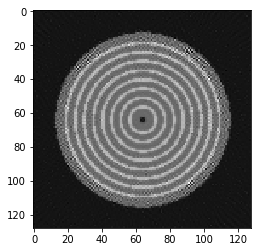

(27000, 16384)
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6673967, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 16388, constraints m = 59776
Cones:	linear vars: 16384
	soc vars: 43392, soc blks: 4
Setup time: 2.23e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.31e-01  1.46e+00  1.00e+00 -1.34e+04  2.46e+02  0.00e+00  1.03e+00 
   100| 4.15e-02  1.50e-01  2.84e-02  9.41e+02  9.96e+02  5.46e-12  3.88e+01 
   200| 8.14e-03  5.61e-02  1.33e-02  1.

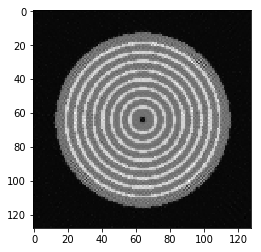

In [46]:
noise = np.random.randn(*y.shape)
y_noise = y + 0.25*noise


for l in np.linspace(0.0, 10.0, 5):
    x = reconstruct_with_constraints(A, y_noise, Mask, Tmat_sparse, Dx, reg_lambda=l)
    print(l)
    plt.imshow(x.value.reshape(128,128), cmap='gray')
    plt.show()

In [17]:
def reconstruct_scipy_nonlinear_cons(A, y):
    def loss_fn(x):
        np.linalg.norm(A @ x -y)
        
    scipy.optimize.NonlinearConstraint(loss_fns, lb=0.0, up=np.inf)

In [19]:
reconstruct_scipy_nonlinear_cons(A,y)

AttributeError: module 'scipy.optimize' has no attribute 'NonlinearConstraint'

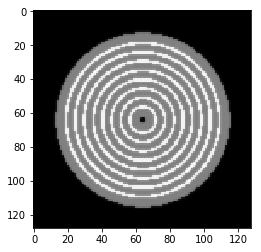

In [20]:
plt.imshow(x.value.reshape(128,128), cmap='gray')

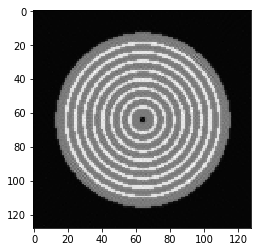

In [36]:
plt.imshow(x.value.reshape(128,128), cmap='gray')

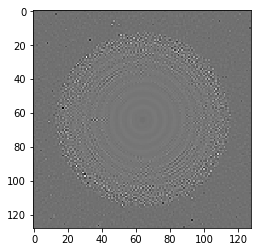

In [38]:
plt.imshow(x.value.reshape(128,128), cmap='gray')

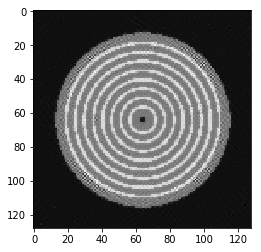

In [40]:
plt.imshow(x.value.reshape(128,128), cmap='gray')

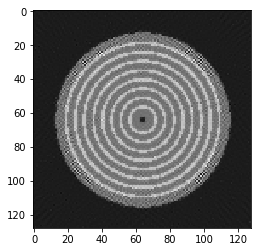

In [42]:
plt.imshow(x.value.reshape(128,128), cmap='gray')

(27000, 16384)
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6757313, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 3000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 32770, constraints m = 76156
Cones:	linear vars: 49152
	soc vars: 27004, soc blks: 2
Setup time: 2.29e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.32e+00  1.52e+00  1.00e+00 -3.62e+03  2.85e+01  1.20e-12  9.61e-01 
   100| 1.43e-02  1.79e-02  2.59e-01  1.03e+01  1.78e+01  1.74e-13  3.19e+01 
   200| 2.01e-02  3.30e-02  2.03e-03  4.

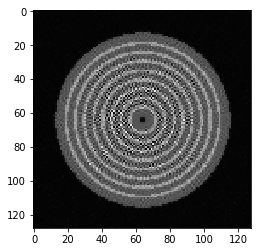

(27000, 16384)
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6757313, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 3000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 32770, constraints m = 76156
Cones:	linear vars: 49152
	soc vars: 27004, soc blks: 2
Setup time: 2.27e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.32e+00  2.41e+00  1.00e+00 -1.35e+05  1.07e+03  4.50e-11  9.49e-01 
   100| 7.25e-03  1.48e-02  1.45e-01  3.41e+02  4.56e+02  4.81e-12  3.18e+01 
   200| 1.40e-02  2.86e-02  1.26e-01  8.

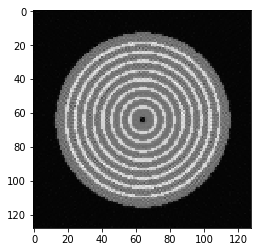

(27000, 16384)
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6757313, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 3000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 32770, constraints m = 76156
Cones:	linear vars: 49152
	soc vars: 27004, soc blks: 2
Setup time: 2.31e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.32e+00  2.43e+00  1.00e+00 -2.68e+05  2.11e+03  8.92e-11  8.93e-01 
   100| 5.88e-03  1.26e-02  9.37e-02  6.37e+02  7.68e+02  2.17e-11  3.20e+01 
   200| 4.39e-03  8.54e-03  1.04e-01  8.

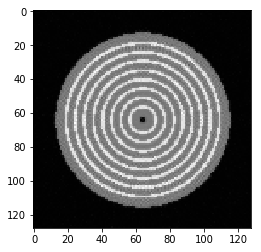

(27000, 16384)
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6757313, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 3000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 32770, constraints m = 76156
Cones:	linear vars: 49152
	soc vars: 27004, soc blks: 2
Setup time: 2.33e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.32e+00  2.44e+00  1.00e+00 -4.01e+05  3.16e+03  1.33e-10  7.73e-01 
   100| 7.73e-03  1.47e-02  3.31e-02  1.42e+03  1.33e+03  5.57e-12  3.12e+01 
   200| 1.65e-02  2.53e-02  4.16e-01  1.

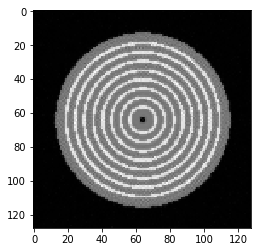

(27000, 16384)
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6757313, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 3000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 32770, constraints m = 76156
Cones:	linear vars: 49152
	soc vars: 27004, soc blks: 2
Setup time: 2.27e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.32e+00  2.44e+00  1.00e+00 -5.34e+05  4.20e+03  1.77e-10  8.98e-01 
   100| 5.63e-03  1.24e-02  4.24e-02  1.52e+03  1.40e+03  3.28e-11  3.16e+01 
   200| 2.27e-03  4.28e-03  6.94e-02  1.

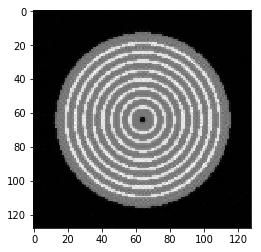

(27000, 16384)
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6757313, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 3000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 32770, constraints m = 76156
Cones:	linear vars: 49152
	soc vars: 27004, soc blks: 2
Setup time: 2.30e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.32e+00  2.44e+00  1.00e+00 -6.66e+05  5.25e+03  2.22e-10  1.01e+00 
   100| 6.27e-03  1.30e-02  6.68e-02  1.48e+03  1.69e+03  3.85e-11  3.18e+01 
   200| 1.91e-03  3.80e-03  6.68e-02  1.

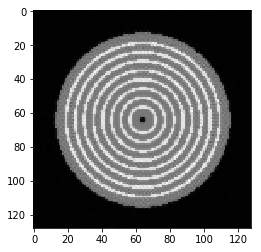

In [56]:
for l in np.linspace(0.01, 2.5, 6):
    x = reconstruct_with_constraints(A, y_noise, Mask, Tmat_sparse, Dx, reg_lambda=l)
    print(l)
    plt.imshow(x.value.reshape(128,128), cmap='gray')
    plt.show()